# 💀 Carbon Prophet 🔮

Predicting Atmospheric Carbon Dioxyde levels with Facebook _Prophet_, a time series forecasting tool aimed at business. 

Data: [NOAA’s Earth System Research Lab in Mauna Loa, Hawaii](https://www.esrl.noaa.gov/gmd/ccgg/trends/), see also the [Keeling Curve](https://en.wikipedia.org/wiki/Keeling_Curve).  
API: [💀 Carbon Doomsday](https://carbondoomsday.com/)   
Prediction: [Facebook Prophet](https://facebook.github.io/prophet/)   
 ⚠ check new data source: http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record and https://scripps.ucsd.edu/programs/keelingcurve/
 
weekly data: http://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html

In [1]:
# Imports
from datetime import datetime, timedelta
# data request and handling
import requests
import io
import pandas as pd
# prediction
from fbprophet import Prophet
# visualisation
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Get data from the Carbondoomsday API.  

In [3]:
url = 'http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/flask_co2/daily/daily_flask_co2_mlo.csv'
response = requests.get(url).content

ConnectionError: HTTPSConnectionPool(host='scrippsco2.ucsd.eduassets', port=443): Max retries exceeded with url: /data/atmospheric/stations/flask_co2/daily/daily_flask_co2_mlo.csv (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7ff46ea3a128>: Failed to establish a new connection: [Errno -2] Name or service not known',))

In [33]:
csv = io.StringIO(response.decode('utf-8'))
data_lines = csv.readlines()[69:] # first 70 lines are text
data_lines
# next: read this in pandas, but it now a list of strings
# pd.read_csv(data_lines)

['1960-03-30, 12:00, 22005.50, 1960.245,  2,  0, 318.27\n',
 '1960-03-31, 16:00, 22006.67, 1960.248,  2,  0, 318.29\n',
 '1960-04-23, 10:30, 22029.44, 1960.310,  3,  4, 318.61\n',
 '1960-04-24, 08:00, 22030.33, 1960.312,  3,  0, 319.33\n',
 '1960-07-03, 15:20, 22100.64, 1960.504,  2,  4, 320.35\n',
 '1960-07-17, 17:00, 22114.71, 1960.543,  2,  4, 315.95\n',
 '1960-08-01, 15:05, 22129.63, 1960.584,  2,  4, 319.37\n',
 '1960-08-18, 10:00, 22146.42, 1960.630,  2,  0, 315.56\n',
 '1960-10-06, 14:48, 22195.62, 1960.764,  2,  0, 312.62\n',
 '1960-11-04, 13:45, 22224.57, 1960.843,  2,  4, 350.39\n',
 '1960-11-25, 13:10, 22245.55, 1960.900,  1,  4, 392.23\n',
 '1960-12-01, 10:50, 22251.45, 1960.917,  2,  0, 316.29\n',
 '1960-12-20, 15:45, 22270.66, 1960.969,  2,  4, 318.19\n',
 '1961-01-04, 12:50, 22285.53, 1961.010,  2,  0, 316.74\n',
 '1961-01-17, 14:00, 22298.58, 1961.045,  2,  0, 317.85\n',
 '1961-02-02, 13:50, 22314.58, 1961.089,  2,  4, 317.62\n',
 '1961-02-17, 11:15, 22329.47, 1961.130,

----- 

In [2]:
start = datetime(1958, 4, 19) # start of carbondoomsday data
today = datetime.now()
days = (today - start).days
print("days to request: ", days)

days to request:  22080


(This is a maximum, at the start of the dataset there is only one measurement per week.)

In [3]:
# make the request
query = 'https://api.carbondoomsday.com/api/co2/?limit=' + str(days)
r = requests.get(query)

In [4]:
# process the returned data
parse_dates = lambda dates: pd.to_datetime(dates)
df = pd.DataFrame(r.json()['results'])
df['date'] = df['date'].apply(parse_dates)
print(len(df.index), " measurements")
df.head()

14638  measurements


date     ppm
0 2018-09-30  405.65
1 2018-09-29  405.35
2 2018-09-27  405.86
3 2018-09-26  405.80
4 2018-09-25  405.35

## Prediction with Facebook Prophet

In [5]:
pred_len = 365 # days to predict
df.columns = ['ds', 'y']

In [6]:
m = Prophet()
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/davidbenque/anaconda/envs/monistic-almanac/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [7]:
future = m.make_future_dataframe(periods=pred_len) 
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
14998 2019-09-26  407.906276  407.074212  408.837782
14999 2019-09-27  407.900946  407.074814  408.748774
15000 2019-09-28  407.886920  407.020549  408.775951
15001 2019-09-29  407.906453  407.012215  408.742411
15002 2019-09-30  407.898465  407.010597  408.739364

## Plotting

In [8]:
# Prepare the data: the last and next 365 days
delta = pd.Timedelta(pred_len, 'D')
d = future.iloc[-1]['ds'] - delta*2
futch = forecast.loc[forecast.ds > d]
data = df.loc[df.ds > d].copy()
data["y"] = data["y"].apply(pd.to_numeric)

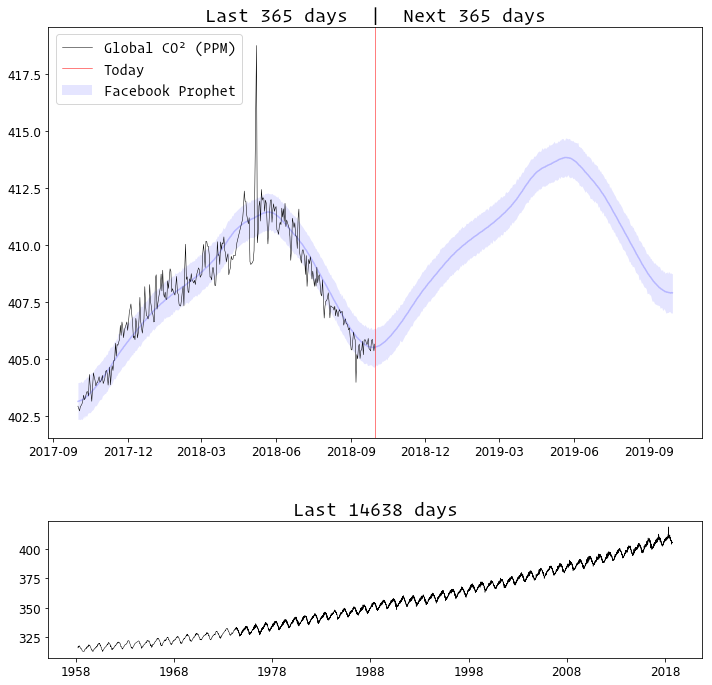

In [9]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax1 = plt.subplot(gs[0])

title_font = {'fontname':'Operator Mono', 'fontsize':20}
axes_font = {'fontname':'Operator Mono', 'fontsize':13}

ax1.set_title("Last {0} days  |  Next {0} days".format(str(pred_len)), **title_font)
# Uncertainty interval
ax1.fill_between(futch['ds'].values, futch['yhat_upper'], futch['yhat_lower'], color= (0,0,1,0.1), lw=0, label="Facebook Prophet")
# Forecast
ax1.plot(futch['ds'], futch['yhat'], color= (0,0,1,0.2), label='_nolegend_')
# Past data
ax1.plot(data['ds'], data['y'], color= 'k', linewidth=0.5, label="Global CO² (PPM)")
# Now line
ax1.axvline(x=df.iloc[0]["ds"], color= 'r', linewidth=0.5, label="Today")
# Legend
ax1.legend(loc="upper left", prop={'size':15, 'family':'Operator Mono'})

ax1 = plt.gca()
ax1.patch.set_facecolor('white')
ax1.tick_params(axis='both', which='both', labelsize=12)

# Second plot with training data
df['y'] = df['y'].apply(pd.to_numeric)
ax2 = plt.subplot(gs[1], facecolor="white")
ax2.set_title("Last {0} days".format(len(df)), **title_font)
ax2.plot(df['ds'], df['y'], color= 'k', linewidth=0.5)
ax2.tick_params(axis='both', which='both', labelsize=12)


plt.tight_layout()
plt.subplots_adjust(hspace=0.3, bottom=0.08)
fig

The area in light blue represents the uncertainty of the probabilistic forecast. As you can see in the GIF below, this decreases as we add more training data. 

![](_notebook/Prophet-Certainty-2.gif "uncertainty")